## 6) 사전 훈련된 워드 임베딩을 이용한 의도 분류(Intent Classification using Pre-trained Word Embedding)

의도 분류(Intent Classification)는 개체명 인식(Named Entity Recognition)과 더불어 챗봇(Chatbot)의 중요 모듈로서 사용되기도 한다. 이번 챕터에서는 사전 훈련된 워드 임베딩(Pre-trained word embedding)을 입력으로 의도 분류를 수행해보자.

의도 분류는 본질적으로는 텍스트 분류임을 기억한다면 쉽게 이해할 수 있다.


### 1.데이터 로드와 전처리

우선 필요한 도구들을 임포트한다.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import urllib.request

데이터를 다운로드한다.


In [2]:
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_text.npy",
                           filename="train_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_text.npy",
                           filename="test_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_label.npy",
                           filename="train_label.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_label.npy",
                           filename="test_label.npy")


('test_label.npy', <http.client.HTTPMessage at 0x7f068a44a0b8>)

In [3]:
ls

glove.6B.100d.txt  glove.6B.50d.txt  sample_data/    train_label.npy
glove.6B.200d.txt  glove.6B.zip      test_label.npy  train_text.npy
glove.6B.300d.txt  glove.6B.zip.1    test_text.npy


npy 파일을 원활하게 로드하기 위해 아래의 설정을 해주어야 한다. (Numpy에서 pickle 파일 허용 여부를 의미하는 allow_pickle 디폴트 값이 False이기 때문에 True로 바꿔주는 과정인데, 사실 딥러닝과 상관있는 내용은 아니므로 자세히 설명하지는 않겠다.)


In [4]:
old = np.load
np.load = lambda *a, **k: old(*a, allow_pickle = True, **k)

각 데이터를 로드하여 리스트로 저장한다.


In [5]:
intent_train = np.load(open('train_text.npy', 'rb')).tolist()
label_train = np.load(open('train_label.npy', 'rb')).tolist()

intent_test = np.load(open('test_text.npy', 'rb')).tolist()
label_test = np.load(open('test_label.npy', 'rb')).tolist()


각 샘플 수를 확인해보자.


In [6]:
print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))

print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


이제 훈련 데이터의 상위 5개 샘플과 레이블을 출력해보자.



In [7]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']


첫번째 샘플을 보면, 'add another song to the cita rom ntica playlist'라는 문장의 레이블은 'AddToPlaylist'이다. 아무래도 이 문장의 의도는 이 곡을 플레이 리스트에 추가해줘라는 의도인 것 같다.

그 외에도 어떤 종류의 카테고리가 있는지 보려면 정확하게 인덱스를 2000씩 +하면서 출력해보면 된다.


In [8]:
print(intent_train[2000:2002])
print(label_train[2000:2002])

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
['BookRestaurant', 'BookRestaurant']


In [9]:
print(intent_train[4000:4002])
print(label_train[4000:4002])

['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
['GetWeather', 'GetWeather']


In [10]:
print(intent_train[6000:6002])
print(label_train[6000:6002])

['rate the current album one points', 'i give a zero rating for this essay']
['RateBook', 'RateBook']


In [11]:
print(intent_train[8000:8002])
print(label_train[8000:8002])

["i'm trying to find the show chant ii", 'find spirit of the bush']
['SearchCreativeWork', 'SearchCreativeWork']


In [12]:
print(intent_train[10000:10002])
print(label_train[10000:10002])

['when is blood and ice cream trilogie playing at the nearest movie theatre \\?', 'show movie schedules']
['SearchScreeningEvent', 'SearchScreeningEvent']


이를 통해 눈치챈 사람도 있겠지만, 사실 이 데이터는 일정한 순서로 배치되어져 있다. 그래서 뒤에서는 이 데이터를 랜덤으로 섞어주는 작업을 해줄 예정이다. 훈련 데이터에 존재하는 레이블의 분포를 그래프로 시각화하여 보겠다.



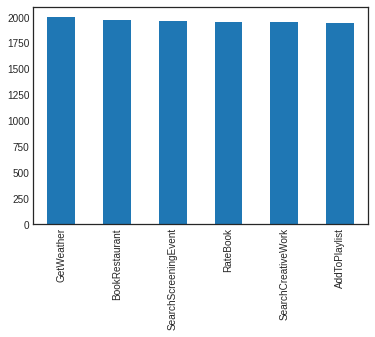

In [13]:
plt.style.use(['seaborn-white'])

temp = pd.Series(label_train)
temp.value_counts().plot(kind = 'bar')

훈련 데이터에는 6개의 카테고리가 존재한다. AddToPlaylist, BookRestaurant, GetWeather , RateBook , SearchCreativeWork, SearchScreeningEvent 각각의 데이터는 약 2,000개씩 존재한다. 이제 label_train과 label_test에 존재하는 6개의 카테고리들을 고유한 정수로 인코딩해보자. 이런 경우에는 사이킷런(sklearn)의 preprocessing.LabelEncoder()가 유용하다.


In [14]:
# 레이블 인코딩. 레이블에 고유한 정수를 부여
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train) # 주어진 고유한 정수로 변환
label_test  = idx_encode.transform(label_test)  # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


label_idx에는 어떤 레이블이 어떤 정수에 맵핑되었는지 저장되어져 있다.

훈련 데이터의 레이블과 테스트 데이터의 레이블 데이터를 상위 5개씩만 출력해보자.


In [15]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
[0 0 0 0 0]


In [16]:
print(intent_test[:5])
print(label_test[:5])

["i 'd like to have this track onto my classical relaxations playlist", 'add the album to my flow espa ol playlist', 'add digging now to my young at heart playlist', 'add this song by too poetic to my piano ballads playlist', 'add this album to old school death metal']
[0 0 0 0 0]


이전에 'AddToPlaylist'라는 문자열로 저장되어져 있었던 레이블이 정수 0으로 변환되었다. 정수 인코딩의 대상은 레이블뿐만 아니라, 의도 문장에 대해서도 해주어야 한다. 우선 의도 문장에 대해서 토큰화를 수행하고, 단어 집합(Vocabulary)을 만든다. 그리고 이어서 정수 인코딩을 수행하여 텍스트 시퀀스를 정수 시퀀스로 변환한다.


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)

sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

단어 집합의 크기를 확인해보겠다.


In [18]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :', vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


패딩을 위해서 훈련 데이터의 길이 분포를 확인해보겠다.


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


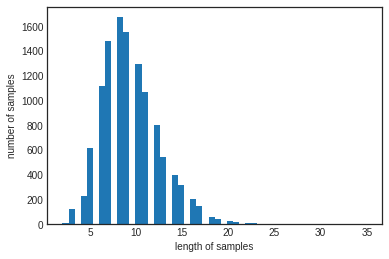

In [19]:
print('문장의 최대 길이 :', max(len(l) for l in sequences))
print('문장의 평균 길이 :', sum(map(len, sequences)) / len(sequences) )

plt.hist([len(s) for s in sequences], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장의 최대 길이는 35이므로, 최대 길이 35로 모든 훈련 데이터를 패딩하겠다. 레이블의 경우에는 다중 클래스 분류를 수행하기 위해서 원-핫 인코딩을 수행한다.


In [20]:
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))

print('전체 데이터의 크기(shape) :', intent_train.shape)
print('레이블 데이터의 크기(shape) :', label_train.shape)


전체 데이터의 크기(shape) : (11784, 35)
레이블 데이터의 크기(shape) : (11784, 6)


In [21]:
print(intent_train[0])
print(label_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
[1. 0. 0. 0. 0. 0.]


이제 훈련 데이터로부터 검증 데이터를 분리하겠다. 그런데 앞서 언급했듯이, 훈련 데이터가 일정한 순서로 배치되어져 있으므로 현재 훈련 데이터에서 앞의 10%나 중간 10%나 뒤의 10%를 검증 데이터로 분리했다가는 운이 나쁘면 특정 레이블의 데이터들만을 분리할 수도 있다. 가령, 검증 데이터에 0번 레이블의 데이터만 있다면 제대로 된 검증이 안 될 것이다. 그래서 검증 데이터로 분리하기 전에 훈련 데이터의 순서를 랜덤으로 섞어주겠다. 우선, 순서가 뒤죽박죽의 정수 시퀀스를 만들어준다.


In [22]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print(indices)

[ 2248  3770 11483 ...  5340  3815  8148]


이제 이 정수의 순서를 인덱스의 순서로 하도록 훈련 데이터를 섞어준다.

In [23]:
intent_train = intent_train[indices]
label_train = label_train[indices]

검증 데이터는 훈련 데이터 중 10%만을 사용한다. 훈련 데이터의 개수에 0.1을 곱하면 몇일까?

In [24]:
n_of_val = int(0.1 * intent_train.shape[0])
print(n_of_val)

1178


1,178이다. 검증 데이터는 1,178개만 사용하도록 훈련 데이터에서 분리해준다.


In [25]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]

X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]

X_test = intent_test
y_test = label_test


In [26]:
print('훈련 데이터의 크기(shape) :', X_train.shape)
print('검증 데이터의 크기(shape) :', X_val.shape)

print('훈련 데이터 레이블의 개수(shape) :', y_train.shape)
print('검증 데이터 레이블의 개수(shape) :', y_val.shape)

print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터의 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape) : (10606, 35)
검증 데이터의 크기(shape) : (1178, 35)
훈련 데이터 레이블의 개수(shape) : (10606, 6)
검증 데이터 레이블의 개수(shape) : (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터의 레이블의 개수 : 600


### 2.사전 훈련된 워드 임베딩 사용하기

여기서는 스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩을 사용한다.

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-01-19 08:23:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-19 08:23:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-19 08:23:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

이미 사전 훈련된 워드 임베딩 챕터에서 사용 방법을 설명하였으므로 자세하게는 설명하지 않겠다. 임베딩 벡터를 로드한다.


In [28]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding = 'utf-8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype = 'float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


총 40만개의 임베딩 벡터가 존재한다. 임의로 사전 훈련된 임베딩에서 단어 'respectable' 임베딩 벡터값과 벡터의 차원을 출력한다.


In [29]:
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

임베딩 벡터의 차원은 100차원이다. 이제 이번 실습에서 사용할 임베딩 테이블을 구축해야 한다. 사전 훈련된 임베딩의 벡터의 차원이 100이므로 임베딩 테이블의 열도 100차원이어야 한다. vocab_size를 행의 크기로, 열의 크기는 100인 테이블을 만든다.


In [30]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

임베딩 테이블의 크기를 확인해보자.

In [31]:
np.shape(embedding_matrix)

(9870, 100)

현재 훈련 데이터에 있는 단어들과 맵핑되는 사전 훈련된 워드 임베딩 벡터의 값을 임베딩 테이블에 저장한다.


In [32]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 3.1D CNN을 이용한 의도 분류

우선 필요한 도구들을 임포트한다.


In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate


모델은 네이버 영화 리뷰 분류하기에서 사용했던 Multi-Kernel 1D CNN 구조를 하이퍼파라미터를 바꿔서 사용한다.


In [34]:
filter_sizes = [2, 3, 5]
num_filters = 512
drop = 0.5

In [35]:
model_input = Input(shape = (max_len, ))
z = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix],
              input_length = max_len, trainable = False)(model_input)

conv_blocks = []

for sz in filter_sizes:
    conv = Conv1D(filters = num_filters, kernel_size = sz,
                  padding = 'valid', activation = 'relu', strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(drop)(z)
model_output = Dense(len(label_idx), activation = 'softmax')(z)

model = Model(model_input, model_output)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 100)      987000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 34, 512)      102912      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 33, 512)      154112      embedding[0][0]                  
______________________________________________________________________________________________

앞서 분리해두었던 검증 데이터로 성능을 점검하면서 훈련을 시작한다. 

In [36]:
hist = model.fit(X_train, y_train,
                 batch_size = 64, 
                 epochs = 10,
                 validation_data = (X_val, y_val))

Epoch 1/10
166/166 [==============================] - 20s 112ms/step - loss: 0.4743 - acc: 0.8338 - val_loss: 0.0721 - val_acc: 0.9762
Epoch 2/10
166/166 [==============================] - 18s 110ms/step - loss: 0.0481 - acc: 0.9878 - val_loss: 0.0392 - val_acc: 0.9898
Epoch 3/10
166/166 [==============================] - 18s 110ms/step - loss: 0.0308 - acc: 0.9917 - val_loss: 0.0402 - val_acc: 0.9847
Epoch 4/10
166/166 [==============================] - 18s 110ms/step - loss: 0.0236 - acc: 0.9932 - val_loss: 0.0360 - val_acc: 0.9907
Epoch 5/10
166/166 [==============================] - 18s 110ms/step - loss: 0.0139 - acc: 0.9960 - val_loss: 0.0287 - val_acc: 0.9898
Epoch 6/10
166/166 [==============================] - 18s 109ms/step - loss: 0.0079 - acc: 0.9984 - val_loss: 0.0482 - val_acc: 0.9839
Epoch 7/10
166/166 [==============================] - 18s 110ms/step - loss: 0.0060 - acc: 0.9994 - val_loss: 0.0423 - val_acc: 0.9898
Epoch 8/10
166/166 [==============================] - 1

저자의 경우 훈련 데이터에서 99%, 검증 데이터에서 98%의 정확도를 얻었다. 정확도와 loss의 변화를 그래프로 시각화해보자.


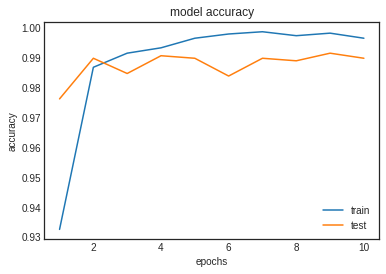

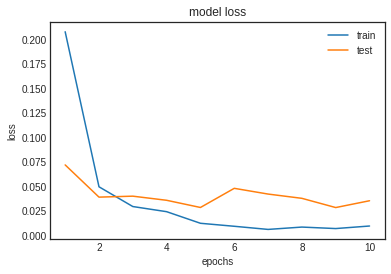

In [37]:
epochs = range(1, len(hist.history['acc']) + 1)

plt.plot(epochs, hist.history['acc'])
plt.plot(epochs, hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(hist.history['loss']) + 1)
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

이제 테스트 데이터에 대해서 평가해보자.

In [38]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_len)

In [39]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis = -1) # 예측된 정수 시퀀스로 변환

In [40]:
y_predicted = idx_encode.inverse_transform(y_predicted) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
y_test = idx_encode.inverse_transform(y_test) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환


In [41]:
print('accuracy :', sum(y_predicted == y_test) / len(y_test))
print('Precision, Recall and F1-Score : \n\n', classification_report(y_test, y_predicted))


accuracy : 0.985
Precision, Recall and F1-Score : 

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       1.00      0.98      0.99       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.93      1.00      0.97       100
SearchScreeningEvent       0.99      0.93      0.96       100

            accuracy                           0.98       600
           macro avg       0.99      0.98      0.98       600
        weighted avg       0.99      0.98      0.98       600



정확도(Accuracy)와 F1-score에서 각각 99%의 정확도를 얻었다.
